# Using NP4VTT: ANN-based VTT model

In this notebook, we show how to use an Artificial Neural Network (ANN) based method to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the ANN, and Pandas to load the dataset:

In [1]:
import sys
sys.path.append('../../src')

In [2]:
import pandas as pd

from py_np4vtt.data_format import Vars
from py_np4vtt.model_ann import ModelANN, ConfigANN
from py_np4vtt.data_import import make_modelarrays, compute_descriptives


Now we read the CSV file:

In [3]:
df = pd.read_table('../../data/Norway2009VTT_demodata.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL`: Travel cost of alternatives 1 [NOK]
* `CostR`: Travel cost of alternatives 2 [NOK]
* `TimeL`: Travel time of alternatives 1 [minutes]
* `TimeR`: Travel time of alternatives 2 [minutes]

NP4VTT detects automatically the _slow and cheap_ and _fast and expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Change currency of travel time to euros and change unit of travel time to hours

In [4]:
# Convert to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

# convert to hours
df[['TimeL','TimeR']] = df[['TimeL','TimeR']] .div(60)

In [5]:
columnarrays = {
    Vars.Id: 'RespID',
    Vars.ChosenAlt: 'Chosen',
    Vars.Cost1: 'CostL',
    Vars.Cost2: 'CostR',
    Vars.Time1: 'TimeL',
    Vars.Time2: 'TimeR',
}

And we create the required arrays:

In [6]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model: RIGHT

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [7]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

Balanced panel: True
No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
No. of unique BVTT points: 15668
Mean chosen BVTT: 10.2977
Minimum of BVTT: 0.6667
Maximum of BVTT: 113.5632


## Step 3: Configure an ANN

The ANN requires the following parameters from the user:

* `hiddenLayerNodes`: A list of length equal to the number of hidden layers. Each element is the number of hidden nodes of each hidden layer.
* `trainingRepeats`: Number of training repeats
* `shufflesPerRepeat`: Number of shuffles of the data (for randomisation of choice situation and data expansion)

Additionally, the user can configure the following options:
* `seed`: Random seed for shuffling and simulation.

The function `ConfigANN` takes the configuration parameters of the ANN and creates an object that is used by the optimisation routine:

In [8]:
config = ConfigANN(hiddenLayerNodes=[10, 10], trainingRepeats= 5, shufflesPerRepeat= 50, seed = None)

Now, we create the ANN object that contains the configuration parameters and the data arrays:

In [9]:
ann = ModelANN(config, model_arrays)

The object `ModelANN` contains the following arrays:

* `X_train:`  Training (85% of the full sample) input data, i.e., the BVTT of each choice set per respondent, and the randomly-chosen choices of the T-1 choice sets.
* `X_test:` Test input data (15% of the full sample)
* `X_full:` Full input data
* `y_train:` Training output data, i.e., the randomly-chosen T choice per respondent.
* `y_test:` Test output data
* `y_full:` Full output data

## Step 4: Train an ANN

Once the ANN is initialised, the `run` method starts the optimisation process:

In [10]:
ll_list, r2_list, vtt_list, est_time, avg_time = ann.run()

Rep 1: CE (train): 0.3617 / CE (test): 0.3645 / LL: -105583.63 / Rho-sq: 0.48
(No VTT recovered for 10 respondents)
Rep 2: CE (train): 0.3656 / CE (test): 0.3671 / LL: -106684.83 / Rho-sq: 0.47
(No VTT recovered for 138 respondents)
Rep 3: CE (train): 0.3634 / CE (test): 0.3654 / LL: -106063.09 / Rho-sq: 0.48
(No VTT recovered for 10 respondents)
Rep 4: CE (train): 0.366 / CE (test): 0.3674 / LL: -106775.26 / Rho-sq: 0.47
(No VTT recovered for 247 respondents)
Rep 5: CE (train): 0.3653 / CE (test): 0.3668 / LL: -106584.88 / Rho-sq: 0.47
(No VTT recovered for 143 respondents)


The training process returns the following information:

* `ll_list:` A numpy array with the log-likelihood of each repetition
* `r2_list:` A numpy array with the Rho-squared of each repetition
* `vtt_list:` A numpy array with the estimated VTT per repetition
* `est_time`: The estimation time in seconds.
* `avg_time`: The average estimation time per repetition.

The following lines present the estimated results:

In [11]:
import numpy as np

# Create dataframe
results = pd.DataFrame(np.c_[ll_list,r2_list],columns=['Log-likelihood','Rho-squared'],index=['Rep. ' + str(i+1) for i in range(len(ll_list))])

print('Training results:')
print('Estimation time: ' + str(round(est_time,4)) + ' seconds.')
print('Average estimation time: ' + str(round(avg_time,4)) + ' seconds.' + '\n')
print(results)

Training results:
Estimation time: 223.9114 seconds.
Average estimation time: 44.7823 seconds.

        Log-likelihood  Rho-squared
Rep. 1  -105583.625368     0.477624
Rep. 2  -106684.828427     0.472175
Rep. 3  -106063.094396     0.475251
Rep. 4  -106775.262959     0.471728
Rep. 5  -106584.877969     0.472670


## Step 5: Visualising the VTT distribution

We create the empirical Cumulative Density Function plot of the VTT distribution. For easy interpretation, we use create a histogram from the CDF. 
We use matplotlib for this:

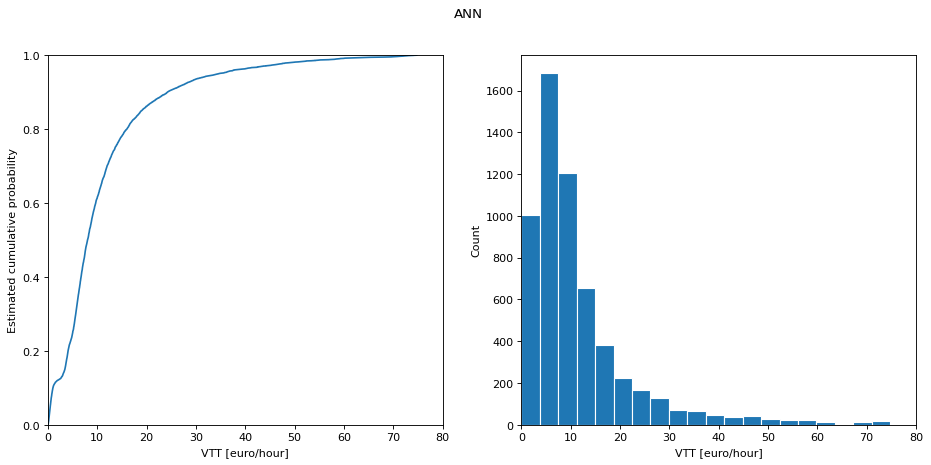

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

vtt_mean = vtt_list.mean(axis=0)
ecdf = ECDF(vtt_mean)

fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=80)

# Plot CDF
ax[0].plot(ecdf.x,ecdf.y)
ax[0].set_xlim(0,80)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('VTT [euro/hour]')
ax[0].set_ylabel('Estimated cumulative probability')

# Plot histogram
ax[1].set_xlim(0,80)
ax[1].set_xlabel('VTT [euro/hour]')
ax[1].set_ylabel('Count')
ax[1].hist(vtt_mean,bins=20,edgecolor="white")
fig.suptitle('ANN')
plt.savefig('outcomes/ann.png')
plt.show()